<a href="https://colab.research.google.com/github/pansplawik/eegParkinsonCognitiveDisorders/blob/master/thirdVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mne

Importowanie pakietów

In [19]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import csv

Ściezki plików

In [21]:
labels = pd.read_csv('C:/Users/splaw/OneDrive/Pulpit/dyplom/eegParkinsonCognitiveDisorders/dataset.csv', sep=';')
labels['PD'] = labels['PD'].replace(2, 1)
path='C:/Users/splaw/OneDrive/Pulpit/dyplom/EEG'

Preprocesing danych

In [22]:
def load_epochs_from_dir(path, labels):
    epochs_array = []
    liczba=1
    filenames = sorted(os.listdir(path))
    for filename, label in zip(filenames, labels['PD']):
      print(filename)
      if filename.endswith('.edf'):
        filepath = os.path.join(path, filename)
        raw = mne.io.read_raw_edf(filepath, preload=True,verbose=False)
        raw.info.set_montage('standard_1020')
        raw.info['bads'].append('Oz')
        annotations = raw.annotations
        for i in range(len(annotations)):
              if annotations.description[i] != "eyes closed":
                annotations.description[i] = "BAD" 
        raw.set_annotations(annotations)
        raw.filter(1, 40, fir_design='firwin')
        events = mne.make_fixed_length_events(raw, duration=1.0)
        unique_events, unique_indices = np.unique(events[:, 0], return_index=True)
        events = events[unique_indices]
        tmin = 0
        tmax = 2
        baseline = (0, 2)
        reject = dict(
              eeg=80e-6,
              )
        epochs = mne.Epochs(raw, events, event_id=None, tmin=tmin, tmax=tmax, baseline=baseline, preload=True,reject_by_annotation='BAD',reject=reject,verbose=False)
        epochs_array.append([epochs, label])
        del raw
        del annotations
    return epochs_array

PSD

In [ ]:
data = load_epochs_from_dir(path,labels)
df = pd.DataFrame(data, columns=['value', 'label'])
df.to_csv('data.csv', index=False)

In [24]:
def psds(epochs_array, labels):
    data = []
    for epochs, label in zip(epochs_array, labels):
        if epochs is not None and len(epochs) > 0:
            epochs_data = epochs.get_data()
            epo_spectrum = mne.time_frequency.psd_array_multitaper(x=epochs_data, sfreq=512, fmin=8,fmax=12, verbose=False)
            psds_epoch, freqs = epo_spectrum
            vector=[]
            for p in psds_epoch:
                p = 10 * np.log10(p)
                vector.append(p)
            vector = np.array(np.mean(vector,axis=0))
            data.append([vector, label])
            del psds_epoch
            del freqs
            del epo_spectrum
    return data

In [25]:
psd = psds([epochs for epochs, label in data], [label for epochs, label in data])
df = pd.DataFrame(psd, columns=['psds', 'label'])
df.to_csv('psd.csv', index=False)

In [26]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_scores(accuracy_scores, precision_scores, recall_scores, f1_scores, typalgorytmu):
    fig, ax = plt.subplots(figsize=(8, 6))
    x_labels = [f"Fold {fold+1}" for fold in range(5)]
    x = np.arange(len(x_labels))
    width = 0.2
    ax.bar(x - 1.5 * width, accuracy_scores, width, label='Accuracy')
    ax.bar(x - 0.5 * width, precision_scores, width, label='Precision')
    ax.bar(x + 0.5 * width, recall_scores, width, label='Recall')
    ax.bar(x + 1.5 * width, f1_scores, width, label='F1 Score')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.set_xlabel('Fold')
    ax.set_ylabel('Scores')
    ax.set_title('Scores for each Fold')
    ax.legend()

    mean_accuracy = np.mean(accuracy_scores)
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores)

    print("Mean Accuracy:", mean_accuracy)
    print("Mean Precision:", mean_precision)
    print("Mean Recall:", mean_recall)
    print("Mean F1 Score:", mean_f1)
    # Save the figure before showing it
    plt.savefig(f"zdj/{typalgorytmu}812slupki.png")
    plt.show()

In [27]:
def plot_confusion_matrix(confusion_matrix, typalgorytmu):
    total_samples = np.sum(confusion_matrix)
    confusion_matrix_percentage = confusion_matrix / total_samples * 100

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_percentage, annot=True, fmt='.2f', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix [%]')

    # Save the figure before showing it
    plt.savefig(f"zdj/{typalgorytmu}812macierz.png")
    plt.show()


In [28]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

def learningStats(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        train_sizes=np.linspace(.1, 1.0, 5),  # Można dostosować zakres rozmiarów danych treningowych
        cv=5,  # Liczba podziałów cross-validation
        scoring='accuracy',  # Można dostosować metrykę oceny (np. 'accuracy', 'f1', 'roc_auc', etc.)
        n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Wyświetlenie wyników w postaci wykresu
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label='Training accuracy', color='blue')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    plt.plot(train_sizes, test_mean, label='Validation accuracy', color='green')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')
    plt.title('Learning Curve')
    plt.xlabel('Training Samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()


Tworzenie zestawów

In [29]:
from sklearn.model_selection import KFold
k_folds = 5
skf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
X = df['psds']
y = df['label']

C:\Users\splaw\AppData\Local\Temp\ipykernel_17508\1151153815.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  overall_confusion_matrix = np.zeros((2,2), dtype=np.int)


Mean Accuracy: 0.5904761904761905
Mean Precision: 0.620892799151313
Mean Recall: 0.5862937062937063
Mean F1 Score: 0.548530821030821


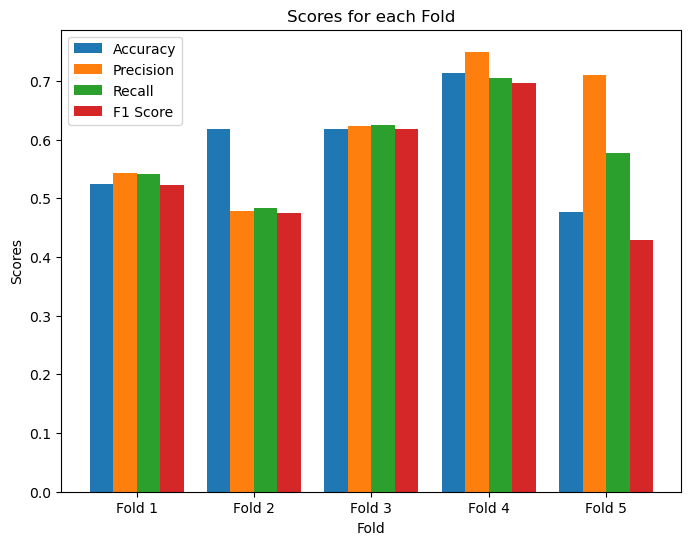

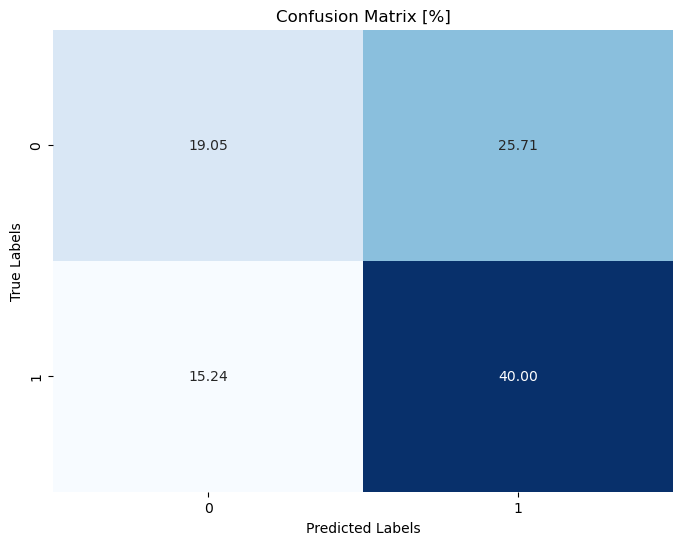

In [30]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
overall_confusion_matrix = np.zeros((2,2), dtype=np.int)
for fold, (train_index, test_index) in enumerate(skf.split(df['psds'],df['label'])):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train = np.array([x for x in X_train]).reshape(len(X_train), -1)
    X_test = np.array([x for x in X_test]).reshape(len(X_test), -1)
    clf = make_pipeline(
        StandardScaler(),
        SVC()
    )
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    confusion_mat = confusion_matrix(y_test, predictions)
    overall_confusion_matrix += confusion_mat
    accuracy_scores.append(accuracy_score(y_test, predictions))
    precision_scores.append(precision_score(y_test, predictions, average='macro'))
    recall_scores.append(recall_score(y_test, predictions, average='macro'))
    f1_scores.append(f1_score(y_test, predictions, average='macro'))

# Plot the scores using the function
plot_scores(accuracy_scores, precision_scores, recall_scores, f1_scores,"svm")

# Plot the confusion matrix using the function
plot_confusion_matrix(overall_confusion_matrix,"svm")

C:\Users\splaw\AppData\Local\Temp\ipykernel_17508\1921051635.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  overall_confusion_matrix = np.zeros((2,2), dtype=np.int)


Mean Accuracy: 0.6380952380952382
Mean Precision: 0.65070649938297
Mean Recall: 0.6327894327894328
Mean F1 Score: 0.6041763835691686


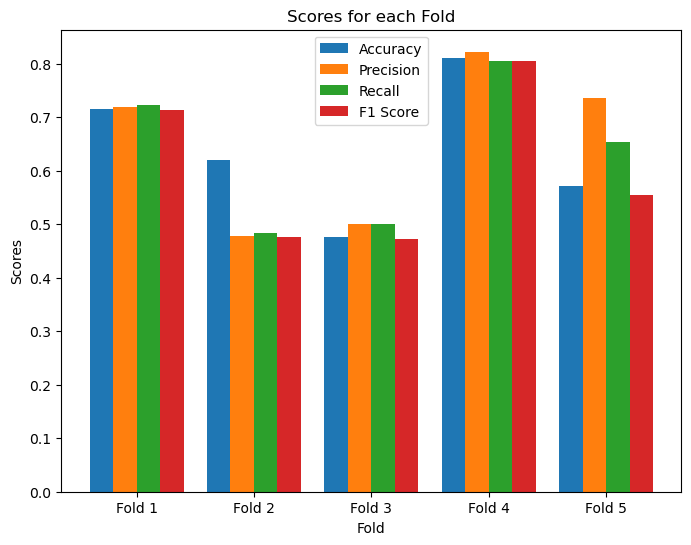

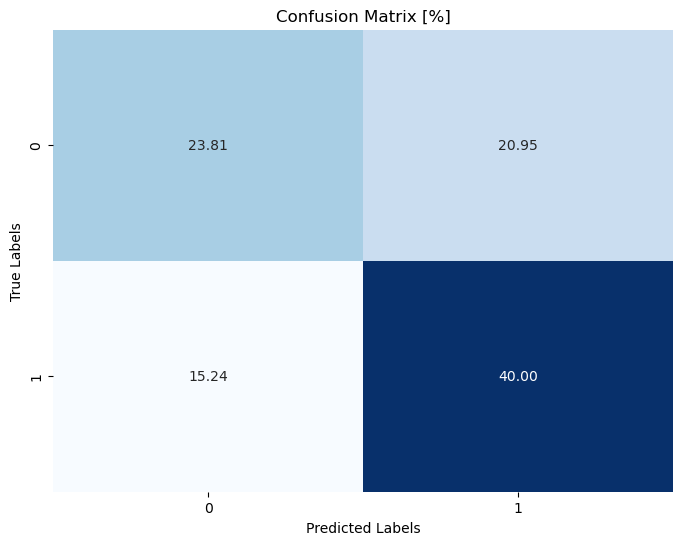

In [31]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
overall_confusion_matrix = np.zeros((2,2), dtype=np.int)
for fold, (train_index, test_index) in enumerate(skf.split(df['psds'],df['label'])):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train = np.array([x for x in X_train]).reshape(len(X_train), -1)
    X_test = np.array([x for x in X_test]).reshape(len(X_test), -1)
    clf = make_pipeline(
        StandardScaler(),
        RandomForestClassifier()
    )
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    confusion_mat = confusion_matrix(y_test, predictions)
    overall_confusion_matrix += confusion_mat
    accuracy_scores.append(accuracy_score(y_test, predictions))
    precision_scores.append(precision_score(y_test, predictions, average='macro'))
    recall_scores.append(recall_score(y_test, predictions, average='macro'))
    f1_scores.append(f1_score(y_test, predictions, average='macro'))

# Plot the scores using the function
plot_scores(accuracy_scores, precision_scores, recall_scores, f1_scores,"forest")

# Plot the confusion matrix using the function
plot_confusion_matrix(overall_confusion_matrix,"forest")

C:\Users\splaw\AppData\Local\Temp\ipykernel_17508\1831097223.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  overall_confusion_matrix = np.zeros((2,2), dtype=np.int)


Mean Accuracy: 0.5714285714285714
Mean Precision: 0.5802532679738562
Mean Recall: 0.5644055944055943
Mean F1 Score: 0.541760287120814


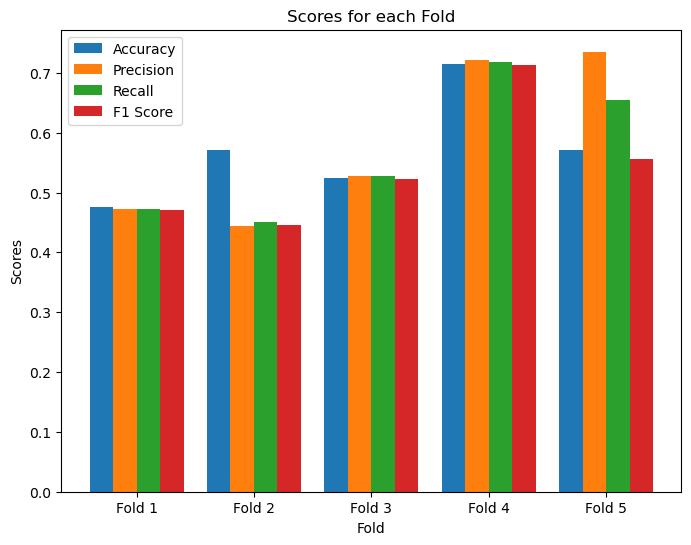

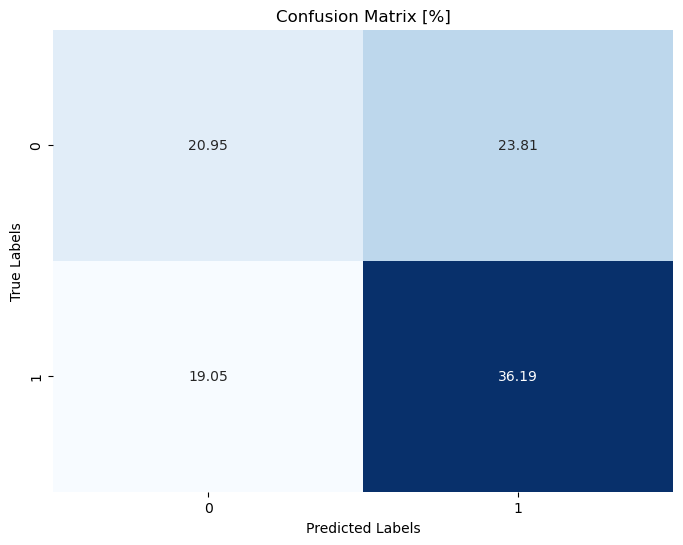

In [32]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
overall_confusion_matrix = np.zeros((2,2), dtype=np.int)
for fold, (train_index, test_index) in enumerate(skf.split(df['psds'],df['label'])):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train = np.array([x for x in X_train]).reshape(len(X_train), -1)
    X_test = np.array([x for x in X_test]).reshape(len(X_test), -1)

    clf = make_pipeline(
        StandardScaler(),
        KNeighborsClassifier()
    )
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    confusion_mat = confusion_matrix(y_test, predictions)
    overall_confusion_matrix += confusion_mat
    accuracy_scores.append(accuracy_score(y_test, predictions))
    precision_scores.append(precision_score(y_test, predictions, average='macro'))
    recall_scores.append(recall_score(y_test, predictions, average='macro'))
    f1_scores.append(f1_score(y_test, predictions, average='macro'))

# Plot the scores using the function
plot_scores(accuracy_scores, precision_scores, recall_scores, f1_scores,"k")

# Plot the confusion matrix using the function
plot_confusion_matrix(overall_confusion_matrix,"k")

C:\Users\splaw\AppData\Local\Temp\ipykernel_17508\2607899814.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  overall_confusion_matrix = np.zeros((2,2), dtype=np.int)


Mean Accuracy: 0.638095238095238
Mean Precision: 0.654798828622358
Mean Recall: 0.635986790986791
Mean F1 Score: 0.6226906445956789


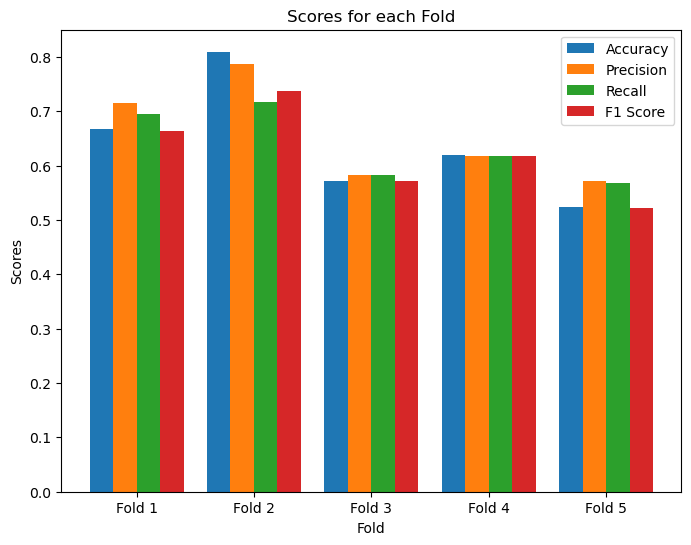

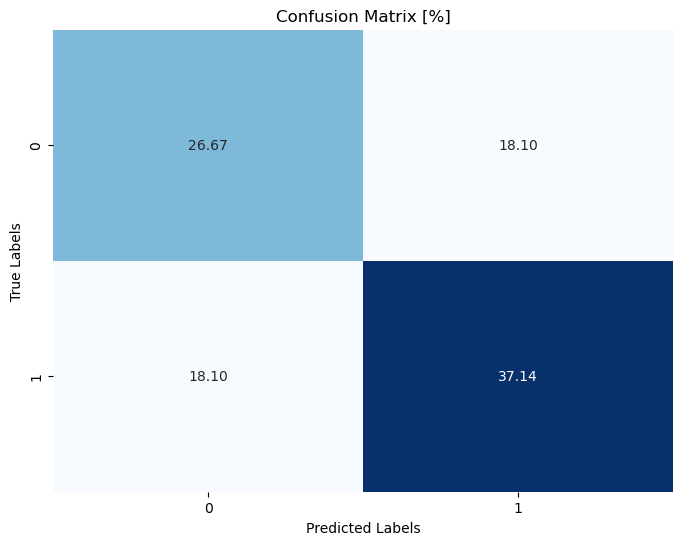

In [33]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
overall_confusion_matrix = np.zeros((2,2), dtype=np.int)
for fold, (train_index, test_index) in enumerate(skf.split(df['psds'],df['label'])):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train = np.array([x for x in X_train]).reshape(len(X_train), -1)
    X_test = np.array([x for x in X_test]).reshape(len(X_test), -1)

    clf = make_pipeline(
        StandardScaler(),
        LogisticRegression()
    )
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    confusion_mat = confusion_matrix(y_test, predictions)
    overall_confusion_matrix += confusion_mat
    accuracy_scores.append(accuracy_score(y_test, predictions))
    precision_scores.append(precision_score(y_test, predictions, average='macro'))
    recall_scores.append(recall_score(y_test, predictions, average='macro'))
    f1_scores.append(f1_score(y_test, predictions, average='macro'))

# Plot the scores using the function
plot_scores(accuracy_scores, precision_scores, recall_scores, f1_scores,"reglog")

# Plot the confusion matrix using the function
plot_confusion_matrix(overall_confusion_matrix,"reglog")

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
X= np.array([x for x in X]).reshape(len(X), -1)

model = RandomForestClassifier()
scores = cross_val_score(model, X, y, cv=5)

print("Mean score of %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
print(scores)

Mean score of 0.65 with a standard deviation of 0.18
[0.42857143 0.85714286 0.80952381 0.42857143 0.71428571]
